In [1]:
# imports
from sklearn.datasets import make_blobs
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import DistanceMetric

# FPT Approximations for Fair k-Min-Sum-Radii

### Creating example data

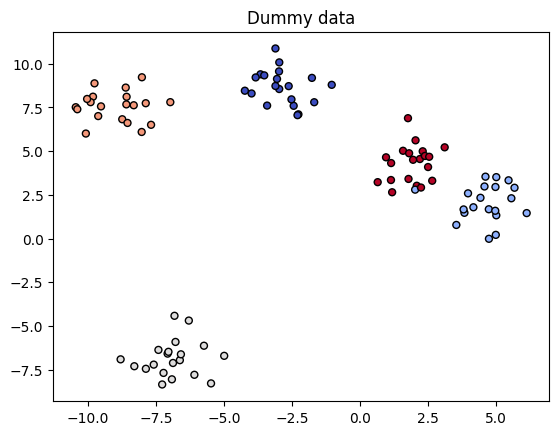

In [2]:
# generate dummy data
points, cluster_membership = make_blobs(
    n_samples=100,
    n_features=2,
    centers=5,
    random_state=42
)

plt.title("Dummy data")
plt.scatter(points[:, 0], points[:, 1], marker='o', c=cluster_membership, s=25, edgecolor="k", cmap="coolwarm")
plt.show()


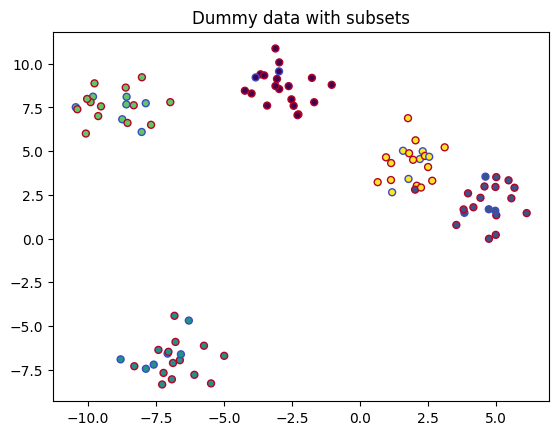

In [3]:
# choosing points to represent two subsets in 1:3 ratio:
subset_membership = np.array([10 if index % 4 == 0 else 200 for index in range(len(points))])


cmap=plt.cm.coolwarm
norm = mcolors.Normalize(vmin=min(subset_membership), vmax=max(subset_membership))
edge_colors = cmap(norm(subset_membership))
plt.title("Dummy data with subsets")
plt.scatter(points[:, 0], points[:, 1], marker='o',c=cluster_membership, s=25, edgecolor=edge_colors)
plt.show()

## The Algorithm

### 1. Constructing unfair clusters that contain the optimal solution\
Necessary subroutines: guessing centers -> k-completion -> Gonzalez, guessing radii 

In [4]:
# distance function
dist = DistanceMetric.get_metric('euclidean')

To better understand the following k_completion implementation, it is helpful to first remember the basics of farthest-first traversal implemented in Gonzalez. This algorithm already achieves a 2-approximation for unfair clustering, which leads to remarkably accurate centers, even if you start with a randomly selected one.

In [ ]:
def gonzalez(points, k):
    points = np.array(points)
    n = len(points)
    centers = []

    start_idx = np.random.choice(n)
    centers.append(points[start_idx])
    
    if(k==1):
        return centers

    while(len(centers) <= k):
        dists = np.min(dist.pairwise(points, np.array(centers)), axis=1) # the axis attribute stops it from returning the same center over and over again
        
        farthest_idx = np.argmax(dists)
        centers.append(points[farthest_idx])

    return np.array(centers)

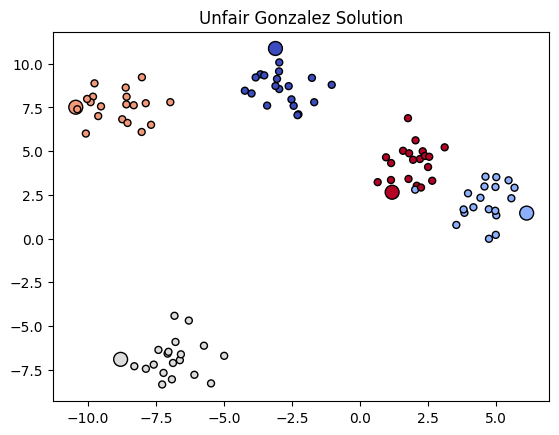

In [6]:
# centers are enlarged
plt.title("Unfair Gonzalez Solution")
sizes = [100 if tuple(point) in map(tuple, gonzalez(points, 5)) else 25 for point in points]
plt.scatter(points[:, 0], points[:, 1], marker='o', c=cluster_membership, s=sizes, edgecolor="k", cmap="coolwarm")
plt.show()

In [ ]:
def k_completion():

SyntaxError: expected ':' (3504672679.py, line 1)